# <center>Setting Things Up</center>

#### Import libraries and allow inline matplotlib output

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

#### Read the dataset into a pandas DataFrame

In [49]:
data = pd.read_csv("dataset.csv")

In [50]:
data

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time
0,ID_6321,39.262605,-85.837372,"Fast Food, Rolls, Burger, Salad, Wraps",$20.00,$50.00,3.5,12,4,30 minutes
1,ID_2882,39.775933,-85.740581,"Ice Cream, Desserts",$10.00,$50.00,3.5,11,4,30 minutes
2,ID_1595,39.253436,-85.123779,"Italian, Street Food, Fast Food",$15.00,$50.00,3.6,99,30,65 minutes
3,ID_5929,39.029841,-85.332050,"Mughlai, North Indian, Chinese",$25.00,$99.00,3.7,176,95,30 minutes
4,ID_6123,39.882284,-85.517407,"Cafe, Beverages",$20.00,$99.00,3.2,521,235,65 minutes
...,...,...,...,...,...,...,...,...,...,...
2014,ID_4366,39.624978,-85.189212,"North Indian, Pizza, Burger, Continental",$40.00,$0.00,-,-,-,30 minutes
2015,ID_319,39.133719,-85.503020,"Awadhi, Bihari",$40.00,$99.00,4.1,118,91,30 minutes
2016,ID_3104,39.662987,-85.950894,"Fast Food, Beverages",$10.00,$50.00,NEW,-,-,30 minutes
2017,ID_4396,39.301765,-85.662768,"Kebab, Fast Food",$10.00,$50.00,-,-,-,30 minutes


#### Sanitizing inputs and converting to a more useful forms

In [51]:
# Cleaning up inputs #################
dataClean = data[["Latitude", "Longitude", "Average_Cost", "Minimum_Order", "Rating", "Votes", "Reviews", "Cook_Time"]]
dataClean = dataClean[~dataClean["Rating"].str.contains("-")]
dataClean = dataClean[~dataClean["Votes"].str.contains("-")]
dataClean = dataClean[~dataClean["Reviews"].str.contains("-")]
dataClean = dataClean[~dataClean["Rating"].str.contains("NEW")]
dataClean = dataClean[~dataClean["Rating"].str.contains("Opening Soon")]
dataClean = dataClean[~dataClean["Average_Cost"].str.contains(",")]
dataClean["Average_Cost"] = dataClean["Average_Cost"].str.slice(start=1) # Get rid of the $
dataClean["Minimum_Order"] = dataClean["Minimum_Order"].str.slice(start=1) # Get rid of the $
dataClean["Cook_Time"] = dataClean["Cook_Time"].str.slice(stop=2)
dataClean["Number_Of_Cuisines"] = data["Cuisines"].str.count(",") + 1 # The number of cuisines offered is no. of commas + 1

# Converting data types ##############
dataClean["Rating"] = pd.to_numeric(dataClean["Rating"], downcast="float")
dataClean["Average_Cost"] = pd.to_numeric(dataClean["Average_Cost"], downcast="integer")
dataClean["Minimum_Order"] = pd.to_numeric(dataClean["Minimum_Order"], downcast="integer")
dataClean["Votes"] = pd.to_numeric(dataClean["Votes"], downcast="integer")
dataClean["Reviews"] = pd.to_numeric(dataClean["Reviews"], downcast="integer")
dataClean["Cook_Time"] = pd.to_numeric(dataClean["Cook_Time"], downcast="integer")

dataClean.dtypes

Latitude              float64
Longitude             float64
Average_Cost            int16
Minimum_Order           int16
Rating                float32
Votes                   int16
Reviews                 int16
Cook_Time                int8
Number_Of_Cuisines      int64
dtype: object

# <center>Conclusion Number 1</center>
-----------------------------------------
Below, you will find a simple linear regression model that attemps to predict the rating of a restaurant based on several different criteria.

#### Make a class to store data and define relevant functions

In [52]:
class Restaurant:
    def __init__(self, **kwargs):
        """
        Possible kwargs: lat, long, avgCost, minOrder, rating, votes, reviews, cookTime, numCuisines
        """
        self.lat = kwargs["lat"]
        self.long = kwargs["long"]
        self.avgCost = kwargs["avgCost"]
        self.minOrder = kwargs["minOrder"]
        self.rating = kwargs["rating"]
        self.votes = kwargs["votes"]
        self.reviews = kwargs["reviews"]
        self.cookTime = kwargs["cookTime"]
        self.numCuisines = kwargs["numCuisines"]
        
    def __str__(self):
        return f"{self.lat}, {self.long}, {self.numCuisines}, {self.avgCost}, {self.minOrder}, {self.votes}, {self.reviews}, {self.cookTime}: {self.rating}"
    
    def squaredError(self, predictedRating):
        return (self.rating - predictedRating) ** 2

# Returns the predicted rating given two vertical vectors as a simple dot product (gives theta_0*x_0 + theta_1*x_1 +...)
def hypothesis(thetaVector, featureMatrix):
    return np.dot(featureMatrix, thetaVector)

def computeCost(thetaVector, featureMatrix, objectList):
    return np.sum([objectList[i].squaredError(hypothesis(thetaVector, featureMatrix[i])) for i in range(len(featureMatrix))]) / (2 * len(featureMatrix))

# Calculates a new value of theta
def gradientDescent(thetaVector, alpha, featureMatrix, expectedMatrix):
    m = len(featureMatrix)
    hyp = hypothesis(thetaVector, featureMatrix)
    loss = hyp - expectedMatrix;
    gradient = featureMatrix.T.dot(loss) / m
    return thetaVector - (alpha * gradient)

#### Convert our data into objects/a numpy array, scale the data, and perform gradient descent

In [53]:
features = []
restaurants = []
for index, row in dataClean.iterrows():
    # The 1 is our intercept (bias)
    #features += [[1, row["Latitude"], row["Longitude"], row["Number_Of_Cuisines"], row["Average_Cost"], row["Minimum_Order"], row["Votes"], row["Reviews"], row["Cook_Time"]]]
    restaurants += [Restaurant(lat=row["Latitude"], long=row["Longitude"], numCuisines=row["Number_Of_Cuisines"], avgCost=row["Average_Cost"], minOrder=row["Minimum_Order"], votes=row["Votes"], reviews=row["Reviews"], cookTime=row["Cook_Time"], rating=row["Rating"])]
stds = {"lat": np.std([i.lat for i in restaurants]), "long": np.std([i.long for i in restaurants]), "numCuisines": np.std([i.numCuisines for i in restaurants]), "avgCost": np.std([i.avgCost for i in restaurants]), "minOrder": np.std([i.minOrder for i in restaurants]), "votes": np.std([i.votes for i in restaurants]), "reviews": np.std([i.reviews for i in restaurants]), "cookTime": np.std([i.cookTime for i in restaurants])}
means = {"lat": np.mean([i.lat for i in restaurants]), "long": np.mean([i.long for i in restaurants]), "numCuisines": np.mean([i.numCuisines for i in restaurants]), "avgCost": np.mean([i.avgCost for i in restaurants]), "minOrder": np.mean([i.minOrder for i in restaurants]), "votes": np.mean([i.votes for i in restaurants]), "reviews": np.mean([i.reviews for i in restaurants]), "cookTime": np.mean([i.cookTime for i in restaurants])}
for r in restaurants:
    r.lat = (r.lat - means["lat"]) / stds["lat"]
    r.long = (r.long - means["long"]) / stds["long"]
    r.numCuisines = (r.numCuisines - means["numCuisines"]) / stds["numCuisines"]
    r.avgCost = (r.avgCost - means["avgCost"]) / stds["avgCost"]
    r.minOrder = (r.minOrder - means["minOrder"]) / stds["minOrder"]
    r.votes = (r.votes - means["votes"]) / stds["votes"]
    r.reviews = (r.reviews - means["reviews"]) / stds["reviews"]
    r.cookTime = (r.cookTime - means["cookTime"]) / stds["cookTime"]
    features += [[1, r.lat, r.long, r.numCuisines, r.avgCost, r.minOrder, r.votes, r.reviews, r.cookTime]]

features = np.array(features)
thetaValues = np.array([[.00001],[.00001],[.00001],[.00001],[.00001],[.00001],[.00001],[.00001],[.00001]])

alpha = 1

thetaCost = computeCost(thetaValues, features, restaurants)
while thetaCost < 100:
    thetaCost = computeCost(thetaValues, features, restaurants)
    print("J(theta): " + str(thetaCost))
    newTheta = gradientDescent(thetaValues, alpha, features, np.array([r.rating for r in restaurants]))
    thetaValues = newTheta

J(theta): 6.644092398363431
J(theta): 281.1109816927111


#### At the moment, this is very broken. It immediately diverges and the cost increases. If I had more time I would split the dataset into training and testing, then test the model, but I just don't have the time to fix it.

# <center> Conclusion Number 2 </center>
----------------------------------
    As shown below, it is rare that a restaurant with a high average cost will have a low rating. Although there is not nearly a large enough correlation between the two factors to draw *heavy* conclusions, this data definitely supports that there is at least some correlation between the two. This information could potentially be used to justify pushing higher-cost restauarants at users, since there is a low chance they will be dissatisfied with their food.

#### Compare Rating to Average Cost

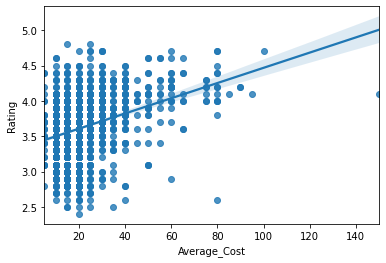

In [54]:
sns.regplot(dataClean["Average_Cost"], dataClean["Rating"])

# <center>Conclusion Number 3</center>
----------------------------------------
The variety of food served at a given restaurant does not impact the preparation times. One would think that a restaurant which is less specialized would be able to provide faster service; however, this is not the case (as is clearly supported by the code below).

#### Compare number of cuisines offered to cook time

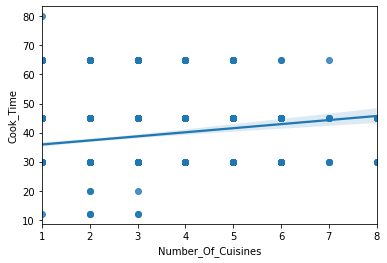

In [55]:
sns.regplot(dataClean["Number_Of_Cuisines"], dataClean["Cook_Time"])

# <center>Conclusion Number 4</center>
---------------------------------------------
Although the linear correlation between reviews vs. rating and votes vs. rating is extremely weak, one can clearly see a pattern emerge: a logarithmic-looking curve. This, however, is most likely just a case of overfitting, and a product of most restaurants having a relatively low number of reviews/votes. What this does provide, though, is that restaurants with higher review or vote counts tend around a 4.0 rating, meaning that they are a safe bet when it comes to choice.

#### Compare number of reviews to rating

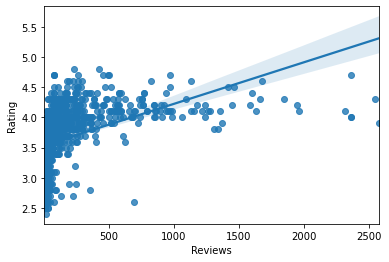

In [56]:
reviews_rating = dataClean[dataClean["Reviews"] < 3000]
sns.regplot(reviews_rating["Reviews"], reviews_rating["Rating"])

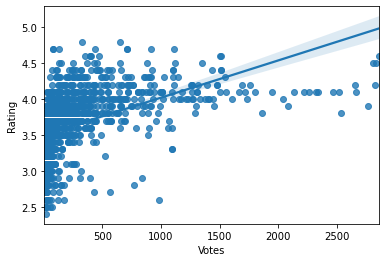

In [57]:
votes_rating = dataClean[dataClean["Votes"] < 3000]
sns.regplot(votes_rating["Votes"], votes_rating["Rating"])